In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Dataset/BrainTumorMRI/BrainTumorMRI.zip" -d "/content/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0726.jpg  
  in

Viusalizing The Dataset to better understand the images available.

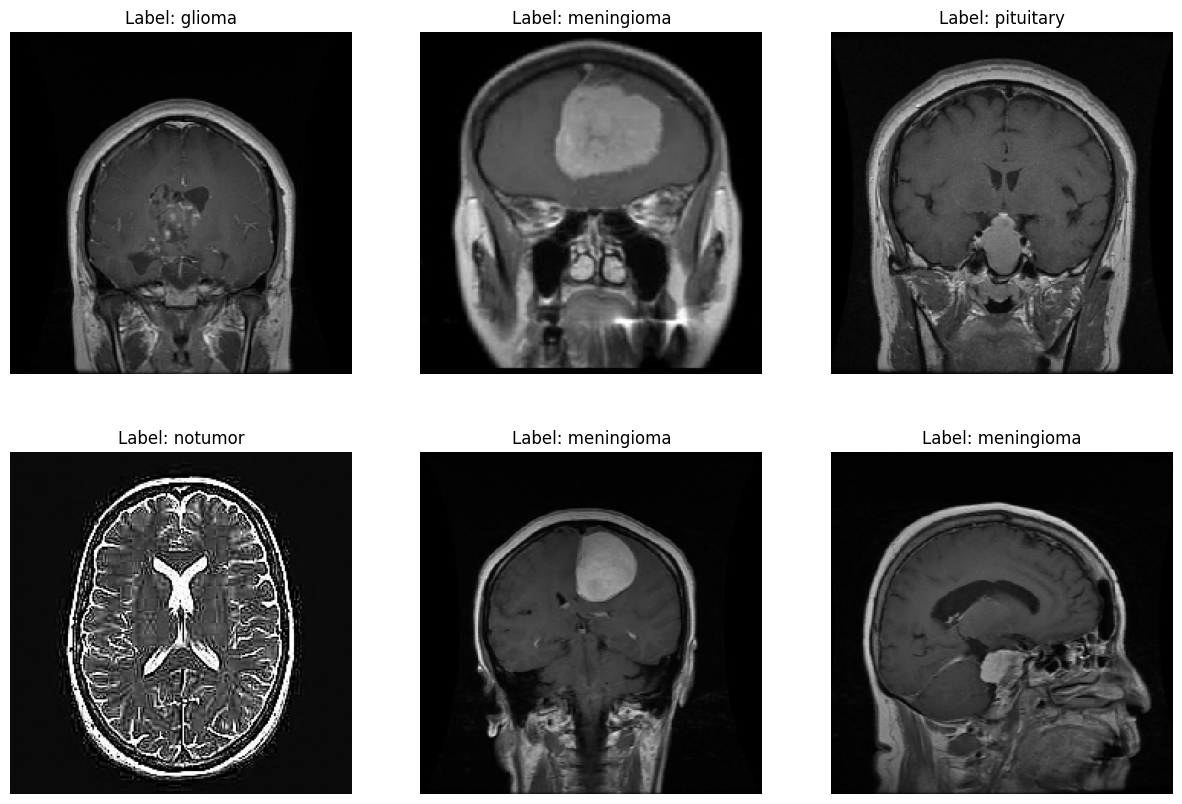

In [20]:
import os
import random

# Specify the path to your dataset
dataset_path = "/content/Dataset/Training"

# Get a list of all image paths in the dataset
all_image_paths = []
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    all_image_paths.extend(image_paths)

# Choose a random subset of images
random_images = random.sample(all_image_paths, k=min(6, len(all_image_paths)))  # Adjust the number as needed

# Plot the images in a grid
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(random_images, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns grid

    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path, target_size_visualization)

    # Display the image
    plt.imshow(img_array[0])

    # Display the label (extracted from the folder name)
    label = image_path.split("/")[-2]  # Assumes the label is the second-to-last part of the path
    plt.title(f"Label: {label}")

    plt.axis("off")

plt.show()


# Preprocessing:

Image Resizing:

Reason: Convolutional Neural Networks (CNNs) often require fixed-size inputs. Resizing images to a consistent size (e.g., 224x224) ensures compatibility with the chosen CNN architecture. In this case, VGG16 was trained on 224x224 images.

Data Augmentation:

Reason: Augmenting the training data with small variations (shear, zoom, horizontal flip) helps improve model generalization. It introduces variability, making the model more robust and less prone to overfitting.

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "/content/Dataset/Training"
test_path = "/content/Dataset/Testing"

# Image size to which all images will be resized
target_size = (224, 224)  # VGG16 was trained on 224x224 images

# Data augmentation (optional but recommended for better model generalization)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow images from the directories using the generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Model Building:

## VGG16 Architecture:

Reason: VGG16 is a well-known CNN architecture that has shown good performance on various image classification tasks. By using a pre-trained model, we leverage features learned from a large dataset (ImageNet) and transfer this knowledge to our task.

If you want to use other pre-trined models like ResNet50 or AlexNet replace the below code for the based model as such:


ResNet50:
```
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
```
AlexNet:


```
from tensorflow.keras.applications import AlexNet
base_model = AlexNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
```




In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [21]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
num_classes = 4
epochs = 20

Custom Layers on Top:

Reason: The pre-trained VGG16 model is used as a feature extractor. The custom layers on top allow the model to adapt to the specific characteristics of the brain tumor classification task.

Dropout Layer:

Reason: Dropout is used to prevent overfitting by randomly deactivating a certain percentage of neurons during training. It encourages the model to learn more robust features.

In [9]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))  # num_classes is the number of output classes

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


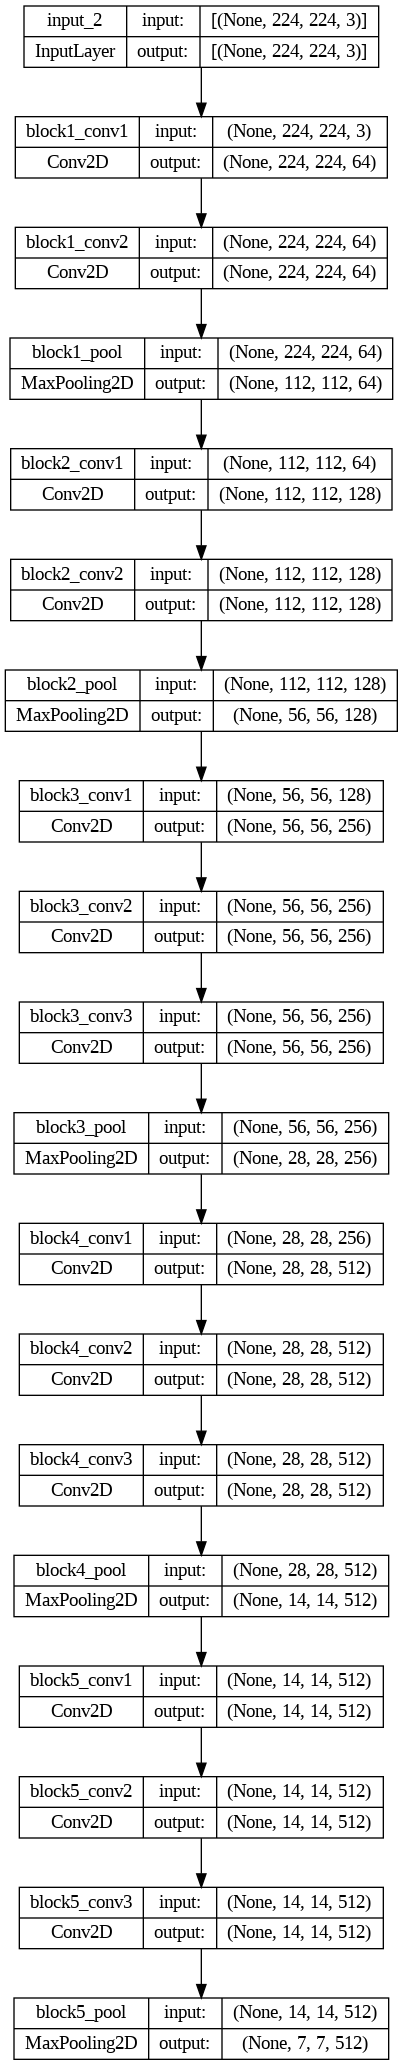

In [23]:
from tensorflow.keras.utils import plot_model

# Save a visual representation of the model architecture to a file
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Categorical Crossentropy Loss:

Reason: Since this is a multi-class classification problem (predicting one of four tumor types), categorical crossentropy is a suitable loss function. It measures the dissimilarity between the predicted probability distribution and the true distribution.

Adam Optimizer:

Reason: The Adam optimizer is an adaptive learning rate optimization algorithm that performs well on a wide range of tasks. It adapts the learning rates for each parameter individually, leading to faster convergence.

In [10]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(lr=0.001),  # You can adjust the learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Tensorboard Integration

In [41]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

In [42]:
log_dir = "/content/logs/"  # Change this to your preferred directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


Wandb Integration

In [36]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [46]:
import wandb

wandb.init(project="your-project-name", name="optional-run-name")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [47]:
from wandb.keras import WandbCallback

wandb_callback = WandbCallback()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


# Train The Model

Steps per Epoch and Validation Steps:

Reason: These parameters define how many batches of data are processed per epoch during training and validation. They are set based on the size of the dataset and the batch size.

In [50]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[tensorboard_callback, WandbCallback()]
)

Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8882

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 0.5s


178/178 [==============================] - 100s 563ms/step - loss: 0.2875 - accuracy: 0.8882 - val_loss: 0.2413 - val_accuracy: 0.9117
Epoch 2/20
178/178 [==============================] - 105s 591ms/step - loss: 0.2815 - accuracy: 0.8979 - val_loss: 0.2677 - val_accuracy: 0.9156
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 0.6s


178/178 [==============================] - 108s 608ms/step - loss: 0.2751 - accuracy: 0.9049 - val_loss: 0.2409 - val_accuracy: 0.9359
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.9025

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 1.0s


178/178 [==============================] - 99s 551ms/step - loss: 0.2576 - accuracy: 0.9025 - val_loss: 0.2033 - val_accuracy: 0.9344
Epoch 5/20
178/178 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9097

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 2.5s


178/178 [==============================] - 113s 635ms/step - loss: 0.2545 - accuracy: 0.9097 - val_loss: 0.1951 - val_accuracy: 0.9461
Epoch 6/20
178/178 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 0.9s


178/178 [==============================] - 97s 542ms/step - loss: 0.2640 - accuracy: 0.9039 - val_loss: 0.1884 - val_accuracy: 0.9414
Epoch 7/20
178/178 [==============================] - 90s 506ms/step - loss: 0.2487 - accuracy: 0.9178 - val_loss: 0.1980 - val_accuracy: 0.9414
Epoch 8/20
178/178 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9134

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 2.5s


178/178 [==============================] - 96s 536ms/step - loss: 0.2391 - accuracy: 0.9134 - val_loss: 0.1746 - val_accuracy: 0.9539
Epoch 9/20
178/178 [==============================] - 90s 508ms/step - loss: 0.2270 - accuracy: 0.9194 - val_loss: 0.2206 - val_accuracy: 0.9445
Epoch 10/20
178/178 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9206

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 0.6s


178/178 [==============================] - 99s 557ms/step - loss: 0.2229 - accuracy: 0.9206 - val_loss: 0.1733 - val_accuracy: 0.9555
Epoch 11/20
178/178 [==============================] - 97s 540ms/step - loss: 0.2239 - accuracy: 0.9169 - val_loss: 0.2175 - val_accuracy: 0.9453
Epoch 12/20
178/178 [==============================] - 93s 522ms/step - loss: 0.2289 - accuracy: 0.9213 - val_loss: 0.1901 - val_accuracy: 0.9414
Epoch 13/20
178/178 [==============================] - 90s 506ms/step - loss: 0.2140 - accuracy: 0.9255 - val_loss: 0.2617 - val_accuracy: 0.9328
Epoch 14/20
178/178 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9113

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 2.8s


178/178 [==============================] - 98s 552ms/step - loss: 0.2433 - accuracy: 0.9113 - val_loss: 0.1679 - val_accuracy: 0.9555
Epoch 15/20
178/178 [==============================] - 90s 508ms/step - loss: 0.2160 - accuracy: 0.9211 - val_loss: 0.2235 - val_accuracy: 0.9422
Epoch 16/20
178/178 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 1.2s


178/178 [==============================] - 95s 536ms/step - loss: 0.1990 - accuracy: 0.9276 - val_loss: 0.1620 - val_accuracy: 0.9617
Epoch 17/20
178/178 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9296

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231219_065922-7fmsnj3g/files/model-best)... Done. 0.6s


178/178 [==============================] - 94s 528ms/step - loss: 0.2206 - accuracy: 0.9296 - val_loss: 0.1530 - val_accuracy: 0.9594
Epoch 18/20
178/178 [==============================] - 97s 543ms/step - loss: 0.2274 - accuracy: 0.9231 - val_loss: 0.1853 - val_accuracy: 0.9523
Epoch 19/20
178/178 [==============================] - 94s 530ms/step - loss: 0.2708 - accuracy: 0.9180 - val_loss: 0.1922 - val_accuracy: 0.9484
Epoch 20/20
178/178 [==============================] - 93s 523ms/step - loss: 0.2642 - accuracy: 0.9178 - val_loss: 0.1978 - val_accuracy: 0.9422


In [ ]:
!tensorboard --logdir="/content/logs/" --host=0.0.0.0 --port=6006

2023-12-19 08:35:55.964269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 08:35:55.964314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 08:35:55.965501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 08:35:56.957160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.15.1 at http://19935bd5d954:6006/

# Save the Model

In [53]:
model.save("/content/BrainTumorMRI.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation


In [54]:
# Assuming you have a list of class names
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Map class indices to class labels
class_labels = {i: class_name for i, class_name in enumerate(class_names)}


41/41 [==============================] - 6s 140ms/step


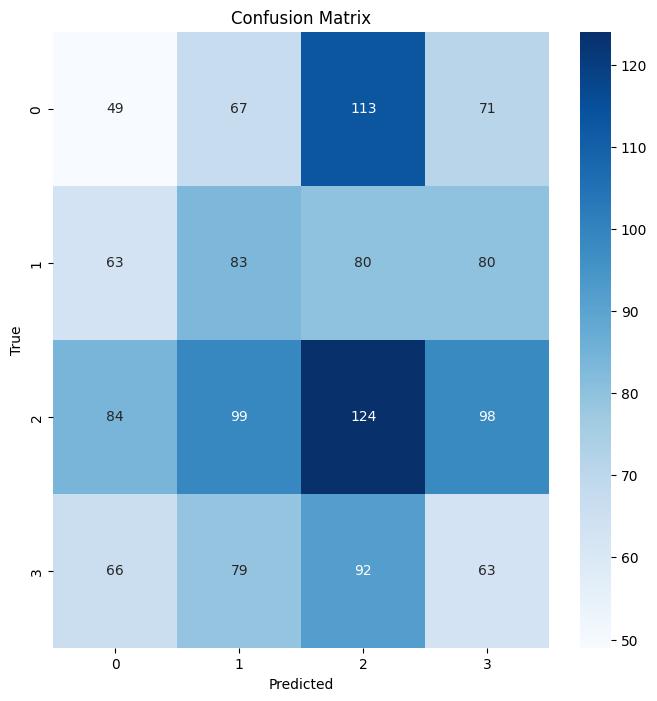

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [64]:
loaded_model = tf.keras.models.load_model("/content/BrainTumorMRI.h5")

1/1 [==============================] - 0s 32ms/step
Predicted class: meningioma


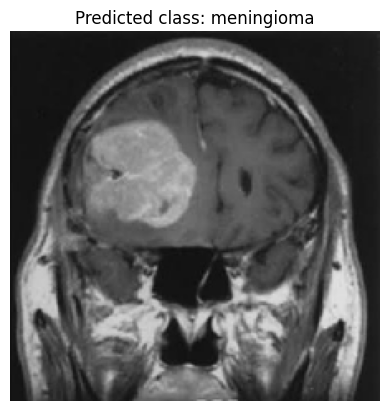

In [70]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load an image for prediction
img = image.load_img("/content/Dataset/Testing/meningioma/Te-me_0021.jpg", target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Make a prediction
predictions = loaded_model.predict(img)

# Assuming you have a list of class labels
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your actual class labels

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")

plt.imshow(img[0].astype(np.uint8))  # Show the image
plt.title(f"Predicted class: {predicted_class_label}")  # Set the title
plt.axis('off')  # Turn off axis labels
plt.show()

In [71]:
# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test Accuracy:", eval_result[1])


40/40 [==============================] - 6s 143ms/step - loss: 0.1920 - accuracy: 0.9438
Test Accuracy: 0.9437500238418579
